# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot, FontLibraryClass
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator, AbstractPropagator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator, Mask
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt, log10
import torch
import numpy
import pandas
from copy import deepcopy
from itertools import product
from typing import Iterable, Callable, Union
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (11.7, 16.5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров экспериметна

In [98]:
# Предпочтительные параметры
size = 9.765625E-6*2
near_N = 512 #2004 #1336
near_length = 10.0E-3
wavelength0 = 420.0E-9
wavelength1 = 700.0E-9
wavelength = (wavelength0 + wavelength1) / 2
var = 5

# Параметры когерентности
spatial_coherence = 5000.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 4

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size)

# Параметры эксперимента
slit_width = size
slit_space = 150.0E-6
distance = 0.5*length*numpy.sqrt((slit_space/(4*wavelength))**2 - 1.0)

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Дистанция:                                {engineering(distance,'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence)}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             560.0 нм
Количество вычислительных пикселей:       512
Количество пикселей маски:                512
Размер оптических элементов:              10.0 мм
Размер пикселя маски:                     19.531 мкм
Дистанция:                                334.784 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           5.0 м
Количество усреднений:                    4


# Инициализация эксперимента и вычисления

In [99]:
propagator = FurrierPropagation(N, length, (wavelength0, wavelength1, var), 1.0, 0.0, distance, border_ratio=0.5).to(device)
initial = (Window(centers=(-slit_space/2, 0), sizes=(slit_width, length))(*[torch.linspace(-length/2,+length/2,N)]*2) + Window(centers=(+slit_space/2, 0), sizes=(slit_width, length))(*[torch.linspace(-length/2,+length/2,N)]*2)).unsqueeze(0).unsqueeze(0).to(device)
initial = initial.expand(1, var, N, N)
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
encoder = incoherent.encoder
decoder = incoherent.decoder

with torch.no_grad():
    result = decoder.forward(propagator.forward(encoder.forward(initial)))
    result = result.abs().cpu()

In [100]:
class Colorizer:
    @staticmethod
    def _colorizer_gaussian(amplitude, average, width_on_half_amplitude, x):
        if torch.is_tensor(x):
            return amplitude * torch.exp(-(2.77*(x-average)**2) / (width_on_half_amplitude**2))
        else:
            return amplitude * numpy.exp(-(2.77*(x-average)**2) / (width_on_half_amplitude**2))

    def __init__(self,
                 R_AM=0.6, R_AV=600.0E-9, R_HW=120.0E-9,
                 r_AM=0.3, r_AV=430.0E-9, r_HW=40.0E-9,
                 G_AM=0.6, G_AV=550.0E-9, G_HW=100.0E-9,
                 B_AM=1.0, B_AV=460.0E-9, B_HW=60.0E-9,
                 I_AM=1.0, I_AV=550.0E-9, I_HW=250.0E-9):
        self.R_parameters = (R_AM, R_AV, R_HW)
        self.r_parameters = (r_AM, r_AV, r_HW)
        self.G_parameters = (G_AM, G_AV, G_HW)
        self.B_parameters = (B_AM, B_AV, B_HW)
        self.I_parameters = (I_AM, I_AV, I_HW)

    def __call__(self, intensity : type(torch.tensor), lambdas : type(torch.tensor), norm=(0.0, 1.0)):
        intensity = intensity.movedim(1,3)
        colored_intensity = torch.zeros([3] + list(intensity.size()))

        R_filter = ((self._colorizer_gaussian(*self.R_parameters, lambdas) + self._colorizer_gaussian(*self.r_parameters, lambdas))* self._colorizer_gaussian(*self.I_parameters, lambdas)).expand_as(intensity)
        G_filter = (self._colorizer_gaussian(*self.G_parameters, lambdas) * self._colorizer_gaussian(*self.I_parameters, lambdas)).expand_as(intensity)
        B_filter = (self._colorizer_gaussian(*self.B_parameters, lambdas) * self._colorizer_gaussian(*self.I_parameters, lambdas)).expand_as(intensity)

        colored_intensity[0] = R_filter * intensity
        colored_intensity[1] = G_filter * intensity
        colored_intensity[2] = B_filter * intensity

        colored_intensity = colored_intensity.movedim(0,4).movedim(3,1)
        colored_intensity = torch.mean(colored_intensity, dim=1)

        maximum = torch.max(colored_intensity)
        minimum = torch.min(colored_intensity)

        colored_intensity = (colored_intensity - minimum) / (maximum - minimum)
        colored_intensity = colored_intensity * (norm[1] - norm[0]) + norm[0]

        return colored_intensity
colorize = Colorizer()

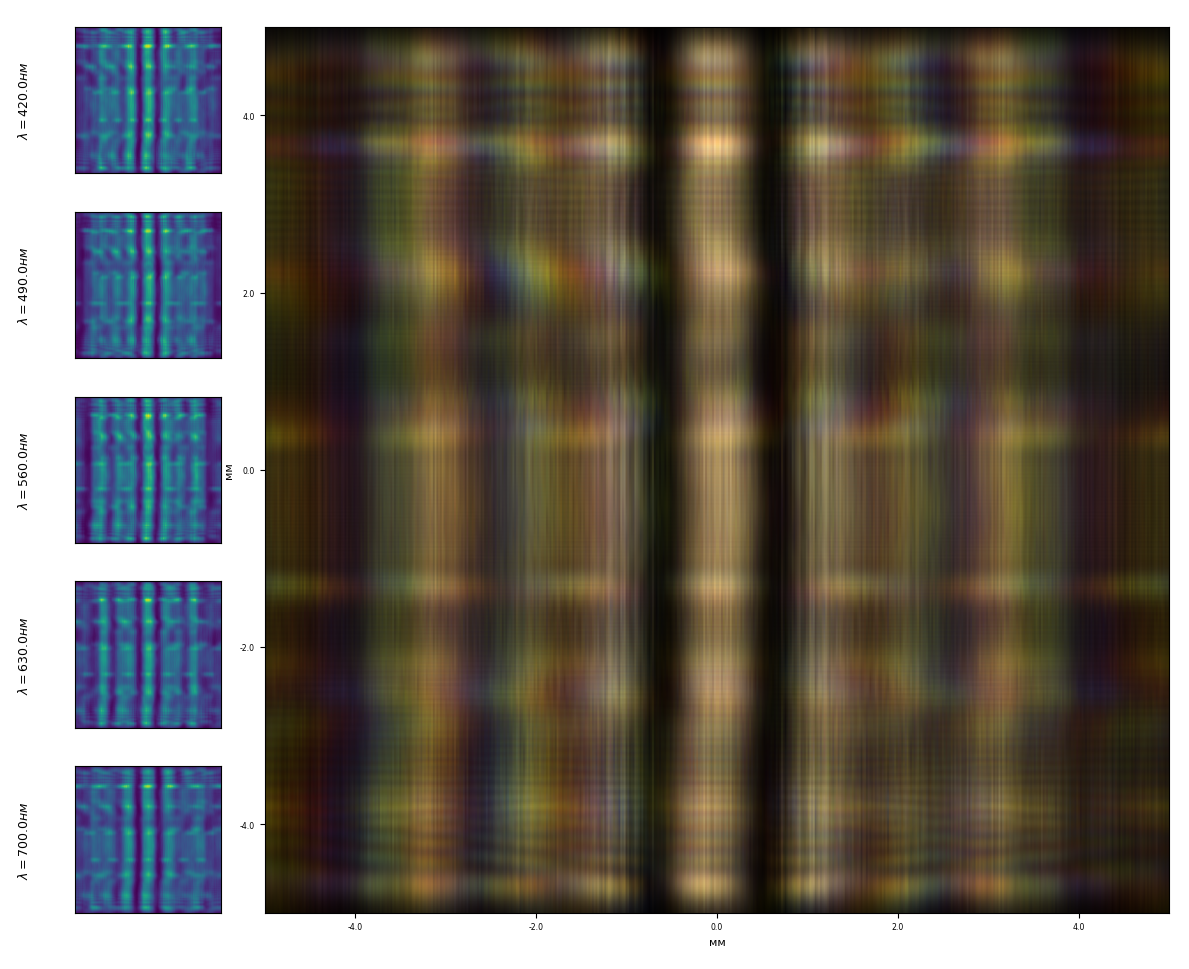

In [101]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

for row, (field, wavelength) in enumerate(zip(result[0], propagator.wavelength.tensor)):
    axes = plot.axes.add(0, row)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(field.swapdims(0,1), aspect='auto')
    plot.description.row.left(f"$\lambda={engineering(wavelength.item(),'м',space='')}$", row)

formatter, unit = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((1,0),(var,var-1))
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
axes.imshow(colorize(result.swapdims(2,3), propagator.wavelength.tensor)[0], aspect='auto', extent=[-length/2,+length/2]*2)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.show()